In [300]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout, Activation, RepeatVector
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import pylab as pl

In [2]:
# setting up random seed
keras.utils.set_random_seed(22)

In [3]:
# loading in our preprocessed text data
data = pd.read_csv('/share/eric-kim/aosc650_data2.csv')
data = data.iloc[:, 1:]
data

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


In [4]:
# defining explanatory variables and labels, then binary encoding my labels 
X = data['review'].values
Y = data['sentiment'].values
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)

In [5]:
# checking my data
X[1]

'wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwell mural decorating every surface terribly well done '

In [6]:
# checking the according label
Y[1]

'positive'

In [7]:
# splitting the data into training and testing
train_X, test_X, train_Y, test_Y = train_test_split(X, encoded_Y, test_size=0.2, random_state=0)

In [8]:
# setting up the number of tokens to be included
# not using any oov tokens
# max length of any array is 300
max_words = 8000
oov_token = ''
max_len = 300

In [9]:
# tokenize and padding sentences
def sequencer(train_x, test_x):
    '''function for tokenizing and sequencing text, and padding'''
    tokenizer = Tokenizer(num_words = max_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_x)
    word_index = tokenizer.word_index
    vocabulary_size = len(tokenizer.word_index)+1
    
    # convert train dataset to sequence and pad sequences
    train_sequences = tokenizer.texts_to_sequences(train_x)
    train_padded = pad_sequences(train_sequences, maxlen = max_len)
    
    # convert Test dataset to sequence and pad sequences
    test_sequences = tokenizer.texts_to_sequences(test_x)
    test_padded = pad_sequences(test_sequences, maxlen = max_len)

    return train_padded, test_padded, vocabulary_size


In [28]:
tokenizer = Tokenizer(num_words = max_words, oov_token = oov_token)
tokenizer.fit_on_texts(train_X)
word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index)+1
    
    # convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
train_padded = pad_sequences(train_sequences, maxlen = max_len)
    
    # convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_X)
test_padded = pad_sequences(test_sequences, maxlen = max_len)



In [10]:
# converting my text into sequences of numbers so they are in machine readble format
# padding the arrays with zeros to allow for equal length
train_padded, test_padded, vocab_size = sequencer(train_X, test_X)

In [115]:
# checking the shape of the vector
train_padded[10].shape

(300,)

In [12]:
# creating a variable for the number of features
n_features = train_padded.shape[1]
n_features 

300

In [162]:
# final model creation
lstm_model = Sequential(name="LSTM_Model")


# embedding layer
lstm_model.add(layers.Embedding(max_words, 100, input_shape=(n_features,)))
lstm_model.add(layers.Dropout(0.3))
lstm_model.add(LSTM(n_features,
                    activation='tanh',
                    return_sequences=False))
lstm_model.add(layers.Dropout(0.3))

# output layer
# using sigmoid due to how it returns a 1 or 0 output 
lstm_model.add(layers.Dense(1, activation = 'sigmoid'))

# Compiling the model
# binary classification so binary crossentropy is used
# accuracy used as the performance metric
lstm_model.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                   metrics=['accuracy'],
                   )

# return a summary of the model
lstm_model.summary()


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 100)       │       800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 300)            │       481,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,501 (4.89 MB)

 Trainable params: 1,281,501 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_lstm = lstm_model.fit(train_padded, train_Y,
                         batch_size=128,
                         epochs=20,
                         #callbacks=[cp_callback],
                         verbose=1,
                         validation_split=0.1)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1180s 4s/step - accuracy: 0.5291 - loss: 0.6928 - val_accuracy: 0.6080 - val_loss: 0.6919
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1195s 4s/step - accuracy: 0.5992 - loss: 0.6911 - val_accuracy: 0.7088 - val_loss: 0.6646
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1011s 4s/step - accuracy: 0.6660 - loss: 0.6463 - val_accuracy: 0.5922 - val_loss: 0.6093
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1006s 3s/step - accuracy: 0.7359 - loss: 0.5761 - val_accuracy: 0.7955 - val_loss: 0.5232
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1095s 4s/step - accuracy: 0.7979 - loss: 0.5183 - val_accuracy: 0.8380 - val_loss: 0.4647
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 962s 3s/step - accuracy: 0.8338 - loss: 0.4532 - val_accuracy: 0.8487 - val_loss: 0.3939
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1022s 4s/step - accuracy: 0.8493 - loss: 0.3826 - val_accuracy: 0.8495 - val_loss: 0.3712
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1015s 3s/step - accuracy: 0.8562 - loss: 0.3604 - v

/tmp/ipykernel_1456/3297843634.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss', c='r')


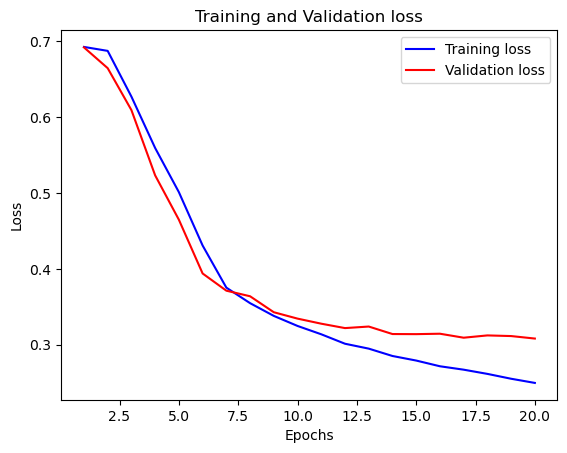

In [16]:
# validation and training loss curves 

plt.clf()
history_dict = history_lstm.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss', c='r')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# epochs 20-30
history_lstm = lstm_model.fit(train_padded, train_Y,
                         batch_size=128,
                         epochs=10,
                         #callbacks=[cp_callback],
                         verbose=1,
                         validation_split=0.1)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1059s 4s/step - accuracy: 0.9048 - loss: 0.2488 - val_accuracy: 0.8798 - val_loss: 0.3119
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1084s 4s/step - accuracy: 0.9041 - loss: 0.2468 - val_accuracy: 0.8817 - val_loss: 0.3094
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1071s 4s/step - accuracy: 0.9087 - loss: 0.2392 - val_accuracy: 0.8832 - val_loss: 0.3082
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1084s 4s/step - accuracy: 0.9089 - loss: 0.2377 - val_accuracy: 0.8850 - val_loss: 0.3080
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1056s 4s/step - accuracy: 0.9120 - loss: 0.2327 - val_accuracy: 0.8848 - val_loss: 0.3142
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1118s 4s/step - accuracy: 0.9110 - loss: 0.2323 - val_accuracy: 0.8850 - val_loss: 0.3119
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1026s 4s/step - accuracy: 0.9141 - loss: 0.2252 - val_accuracy: 0.8850 - val_loss: 0.3104
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 1051s 4s/step - accuracy: 0.9144 - loss: 0.2249 - 

In [21]:
print("LSTM model Score: ", lstm_model.evaluate(test_padded, test_Y, verbose=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - accuracy: 0.8735 - loss: 0.3215
LSTM model Score:  [0.3115347921848297, 0.8769000172615051]


In [280]:
lstm_model.save('lstm_model.keras')

In [186]:
lstm_model = tf.keras.models.load_model('lstm_model.keras')

In [250]:
lstm_model.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │       800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 300)            │       481,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           301 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,844,505 (14.67 MB)

 Trainable params: 1,281,501 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,563,004 (9.78 MB)

In [190]:
import re

def remove_tags(string):
    string = re.sub('<br />','', string)          
    string = re.sub('https://.*','', string)   
    string = re.sub(r'[^a-zA-z0-9\s]', '', string) 
    string = string.lower()
    return string

In [191]:
# defining function that classifies a review 

def predicting(review):
    review_pre = [remove_tags(review)]
    sequence = tokenizer.texts_to_sequences(np.array(review_pre))
    sequence = pad_sequences(sequence, maxlen = max_len)
    sequence.flatten()
    prediction = lstm_model.predict(sequence)
    print(f'Input: {review}\n')
    for pred in prediction:
        if pred > 0.5:
            print('Classification: Positive')
            print(pred)
        else:
            print('Classification: Negative')
            print(pred)

In [307]:
haha = input('Input here:' )
predicting(haha)

Input here: if aosc650 were a movie, id say it was a rather difficult and extensive process, however I really enjoyed the process of learning the course materials as I developed this model as it was super fun and interesting and I look forward to digging deeper into the field of machine learning


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Input: if aosc650 were a movie, id say it was a rather difficult and extensive process, however I really enjoyed the process of learning the course materials as I developed this model as it was super fun and interesting and I look forward to digging deeper into the field of machine learning

Classification: Positive
[0.621694]


In [282]:
haha = input('Input here:' )
predicting(haha)

Input here: this movie was a waste of my time


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Input: this movie was a waste of my time

Classification: Negative
[0.41456398]


In [283]:
haha = input('Input here:' )
predicting(haha)

Input here: this was a pretty good movie id recommend


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Input: this was a pretty good movie id recommend

Classification: Positive
[0.61629635]


In [284]:
haha = input('Input here:' )
predicting(haha)

Input here: i wouldnt recommend this movie to anyone


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Input: i wouldnt recommend this movie to anyone

Classification: Positive
[0.57241344]


In [285]:
haha = input('Input here:' )
predicting(haha)

Input here: Insane graphics, character development, and plot twists. The soundtrack fully immerses one into the dune experience. 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Input: Insane graphics, character development, and plot twists. The soundtrack fully immerses one into the dune experience. 

Classification: Negative
[0.48440558]


In [286]:
haha = input('Input here:' )
predicting(haha)

Input here: One of the best shows from my childhood to this day


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Input: One of the best shows from my childhood to this day

Classification: Positive
[0.6328991]


In [287]:
haha = input('Input here:' )
predicting(haha)

Input here: great cinematics, ingenious transitions, super well-thought-out plot, and very good sound track


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Input: great cinematics, ingenious transitions, super well-thought-out plot, and very good sound track

Classification: Positive
[0.7300885]


In [296]:
haha = input('Input here:' )
predicting(haha)

Input here: Soundtrack was really well done. The acting from Timothy Chalamet and Zendaya really made the film stand out to me. The scenes in the dessert were also really amazing. Overall, a 10/10 movie.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Input: Soundtrack was really well done. The acting from Timothy Chalamet and Zendaya really made the film stand out to me. The scenes in the dessert were also really amazing. Overall, a 10/10 movie.

Classification: Positive
[0.7798554]


In [297]:
haha = input('Input here:' )
predicting(haha)

Input here: it was cool but it was honestly too long and kinda boring, the music was good though


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Input: it was cool but it was honestly too long and kinda boring, the music was good though

Classification: Negative
[0.384614]


In [298]:
haha = input('Input here:' )
predicting(haha)

Input here: life changing experience, the animation is peak and the soundtrack is so fire. One of my favorite movies of all time


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Input: life changing experience, the animation is peak and the soundtrack is so fire. One of my favorite movies of all time

Classification: Positive
[0.72543156]


In [303]:
def predicting2(sequence):
    
    prediction = lstm_model.predict(sequence)
    return prediction

In [294]:
predicting2(test_padded[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[[0.85948837]
 [0.00241927]
 [0.9741494 ]
 [0.54704565]
 [0.9811279 ]
 [0.80121446]
 [0.9913854 ]
 [0.0609048 ]
 [0.02396164]
 [0.0160055 ]
 [0.0431183 ]
 [0.00843989]
 [0.01910583]
 [0.00675247]
 [0.11611567]
 [0.06046705]
 [0.9919852 ]
 [0.31347775]
 [0.08500443]
 [0.00958716]]


In [299]:
word_index

{'': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'time': 6,
 'good': 7,
 'character': 8,
 'story': 9,
 'even': 10,
 'get': 11,
 'would': 12,
 'make': 13,
 'see': 14,
 'really': 15,
 'well': 16,
 'scene': 17,
 'much': 18,
 'bad': 19,
 'great': 20,
 'people': 21,
 'also': 22,
 'first': 23,
 'way': 24,
 'show': 25,
 'thing': 26,
 'made': 27,
 'life': 28,
 'could': 29,
 'think': 30,
 'go': 31,
 'know': 32,
 'watch': 33,
 'love': 34,
 'actor': 35,
 'two': 36,
 'plot': 37,
 'seen': 38,
 'many': 39,
 'year': 40,
 'never': 41,
 'acting': 42,
 'say': 43,
 'end': 44,
 'look': 45,
 'best': 46,
 'little': 47,
 'ever': 48,
 'man': 49,
 'better': 50,
 'take': 51,
 'work': 52,
 'come': 53,
 'still': 54,
 'part': 55,
 'something': 56,
 'director': 57,
 'find': 58,
 'want': 59,
 'back': 60,
 'lot': 61,
 'give': 62,
 'real': 63,
 'guy': 64,
 'watching': 65,
 'performance': 66,
 'play': 67,
 'woman': 68,
 'though': 69,
 'old': 70,
 'funny': 71,
 'another': 72,
 'actually': 73,
 '10': 74,
 'role':